
Exploring and sanitizing the data

The dataset may have duplicates, missing values and other data quality issues that may need to be addressed.  

The class variable may need to be derived in some manner.

You would also need to understand the different attributes, understand their distribution, and correlation with the class or value you are trying to predict



Preprocessing the data

Depending on the classification technique, some attribute types may need to be mapped to others

Some features may need to be transformed to improve performance



Feature selection
Depending on the classification technique, you may want to select a subset of features based on your exploratory analysis
You may also want to use domain knowledge to select or construct appropriate features
Building models and evaluating techniques
You would need to ensure that you are training, tuning hyperparameters of, and rigorously evaluating your chosen method
You may need to try out multiple methods and rigorously compare them.



What if we do supervised vs unsupervised modeling


In [ ]:
##exploring and sanitizing
  ##duplicates
  ##missing values?
  ##other data quality issues (outliers)



##preprocessing
  ##attritubes being mapped to other attributes??
  ##feature transformation to improve performance

##feature selection
  ##may want to use a subset of features based on exploratory analysis
  ##domain knowledge to select or construct appropriate features

##Build the model
  ##tuning hyperparameters
  ##compare models
  ##get deep in that comparison



In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
df = diabetes_130_us_hospitals_for_years_1999_2008.data

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
X_for_model = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y_for_model = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def fit_one_hot_encode(df_train):
    object_cols = df_train.select_dtypes(include=['object']).columns.tolist()

    # Create a OneHotEncoder instance
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the training data
    ohe.fit(df_train[object_cols])

    # Transform the training data
    encoded_data = ohe.transform(df_train[object_cols])

    # Create feature names for the encoded features
    feature_names = ohe.get_feature_names_out(object_cols)

    # Create a DataFrame for the encoded features
    encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df_train.index)

    # Drop the original object columns and add the encoded features
    df_train = df_train.drop(columns=object_cols)
    df_train = pd.concat([df_train, encoded_df], axis=1)

    return df_train, ohe

def transform_one_hot_encode(df_test, ohe):
    object_cols = df_test.select_dtypes(include=['object']).columns.tolist()

    # Transform the test data using the fitted encoder
    encoded_data = ohe.transform(df_test[object_cols])

    # Create feature names for the encoded features
    feature_names = ohe.get_feature_names_out()

    # Create a DataFrame for the encoded features
    encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df_test.index)

    # Drop the original object columns and add the encoded features
    df_test = df_test.drop(columns=object_cols)
    df_test = pd.concat([df_test, encoded_df], axis=1)

    return df_test

# Example usage
X_train_encoded, encoder = fit_one_hot_encode(X_train)
X_test_encoded = transform_one_hot_encode(X_test, encoder)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
print(len(X_train_encoded.columns))
print(len(X_test_encoded.columns))

2382
2382


In [5]:
from os import ST_NOSUID
##find correlation
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Train a Random Forest and extract feature importances
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [6]:
feature_importances = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Bar Plot
plt.figure(figsize=(10, 500))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd

def remove_duplicates(df):
  # Use the drop_duplicates method to remove duplicate rows.
  # The keep='first' argument ensures that the first occurrence of each duplicate row is kept.
  df_no_duplicates = df.drop_duplicates(keep='first')

  # Reset the index of the new DataFrame.
  df_no_duplicates = df_no_duplicates.reset_index(drop=True)

  return df_no_duplicates

print(len(X))
print(len(remove_duplicates(X)))
##looks like there are no duplicates

101766
101766


In [9]:
# Select columns based on feature importance
selected_columns = [
    X_train_encoded.columns[i]
    for i in range(len(model.feature_importances_))
    if model.feature_importances_[i] > 0.005
]

# Create new DataFrames using the selected columns
X_data_formodel_important_only_train = X_train_encoded[selected_columns]
X_data_formodel_important_only_test = X_test_encoded[selected_columns]

# Validate shapes
print("Train shape:", X_data_formodel_important_only_train.shape)
print("Test shape:", X_data_formodel_important_only_test.shape)

Train shape: (81412, 37)
Test shape: (20354, 37)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}
scaler = StandardScaler()
X_scaled_data_important_train = scaler.fit_transform(X_data_formodel_important_only_train)
X_scaled_data_important_test = scaler.transform(X_data_formodel_important_only_test)
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_scaled_data_important_train)
X_test_pca = pca.transform(X_scaled_data_important_test)

search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, n_jobs=-1)
search.fit(X_train_pca, y_train)
y_pred_Random_pca = search.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred_Random_pca)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


NameError: name 'accuracy_score' is not defined

In [ ]:
##scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
scaler = StandardScaler()
X_scaled_data_important_train = scaler.fit_transform(X_data_formodel_important_only_train)
X_scaled_data_important_test = scaler.transform(X_data_formodel_important_only_test)
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_scaled_data_important_train)
X_test_pca = pca.transform(X_scaled_data_important_test)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.05568449 0.03373537 0.03032959 0.02859276 0.02625117 0.02545382
 0.02497919 0.02459926 0.02371651 0.0227865  0.02207314 0.02065429
 0.01983378 0.01901127 0.01731906 0.01717416 0.01700965 0.01650816
 0.01596089 0.01553632 0.01524854 0.01471754 0.01447251 0.01414766
 0.01400709 0.01367072 0.01340948 0.01314281 0.01313474 0.01287822
 0.01282087 0.01276256 0.0126685  0.0125885  0.01253238 0.01239045
 0.01234008 0.01220442 0.01217246 0.0120923  0.01194464 0.01178053
 0.01160665 0.01142714 0.01136812 0.01132217 0.01104864 0.01079517
 0.01053357 0.01039042 0.01009859 0.01006654 0.009626   0.00919599
 0.00901726]
Cumulative variance explained: 0.9008326478979526


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
y_pred = knn.predict(X_test_pca)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
y_pred_Random = model.predict(X_test_encoded)
accuracy_Random = accuracy_score(y_test, y_pred_Random)
print("Accuracy:", accuracy_Random)
##PCA and One-Hot-Encoded with dropped importance got lower accuracy

Accuracy: 0.4575022108676427
Accuracy: 0.5844060135599882


Accuracy: 0.4575022108676427
Accuracy: 0.5844060135599882

In [1]:
##let's try with every value from One-Hot-Encoded, scaled and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)
pca = PCA(n_components=0.9)
X_train_encoded_pca = pca.fit_transform(X_train_encoded_scaled)
X_test_encoded_pca = pca.transform(X_test_encoded_scaled)
##knn_six = KNeighborsClassifier(n_neighbors=6)
##knn_six.fit(X_train_encoded_pca, y_train)
##y_pred_knn_full_OneHot_Scaled_PCA = knn_six.predict(X_test_encoded_pca)
##from sklearn.metrics import accuracy_score
##accuracy = accuracy_score(y_test, y_pred_knn_full_OneHot_Scaled_PCA)
##print("Accuracy:", accuracy)


NameError: name 'X_train_encoded' is not defined

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Accuracy: 0.48275523238675444

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, n_jobs=-1)
search.fit(X_train_encoded_pca, y_train)
y_pred_Random_pca = search.predict(X_test_encoded_pca)
accuracy = accuracy_score(y_test, y_pred_Random_pca)
print("Accuracy:", accuracy)

NameError: name 'X_train_encoded_pca' is not defined

In [ ]:
import pandas as pd
import numpy as np
##function to check the percentage of values in a category that are not available
##to tell if we should use the column or not
value_counts = X['weight'].value_counts(normalize=True) * 100
print(value_counts)
nan_count = X['weight'].isna().sum()
print(nan_count)
print(len(X['weight'])-nan_count)
##weight has only 3,000 values, not worth including...



weight
[75-100)     41.789177
[50-75)      28.057554
[100-125)    19.549578
[125-150)     4.535502
[25-50)       3.034094
[0-25)        1.501408
[150-175)     1.094776
[175-200)     0.344073
>200          0.093838
Name: proportion, dtype: float64
98569
3197


In [ ]:
##drop the weight
X = X.drop('weight', axis=1, errors='ignore')

   0
0  1
1  2
2  3
3  4


In [ ]:
print(X.columns)

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')


In [ ]:
##label encoding to look more at the data
from sklearn.preprocessing import LabelEncoder

##for every column that is dtype='object', apply label encoding
##because we need to have the numbers to check it out
def label_encode_object_columns(df):
    object_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Create a LabelEncoder instance
    le = LabelEncoder()

    # Apply label encoding to each object column
    for col in object_cols:
        df[col] = le.fit_transform(df[col])

    return df
X_labelencoded_weight_removed = label_encode_object_columns(X)
print(X_labelencoded_weight_removed.head)

<bound method NDFrame.head of         race  gender  age  admission_type_id  discharge_disposition_id  \
0          2       0    0                  6                        25   
1          2       0    1                  1                         1   
2          0       0    2                  1                         1   
3          2       1    3                  1                         1   
4          2       1    4                  1                         1   
...      ...     ...  ...                ...                       ...   
101761     0       1    7                  1                         3   
101762     0       0    8                  1                         4   
101763     2       1    7                  1                         1   
101764     2       0    8                  2                         3   
101765     2       1    7                  1                         1   

        admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


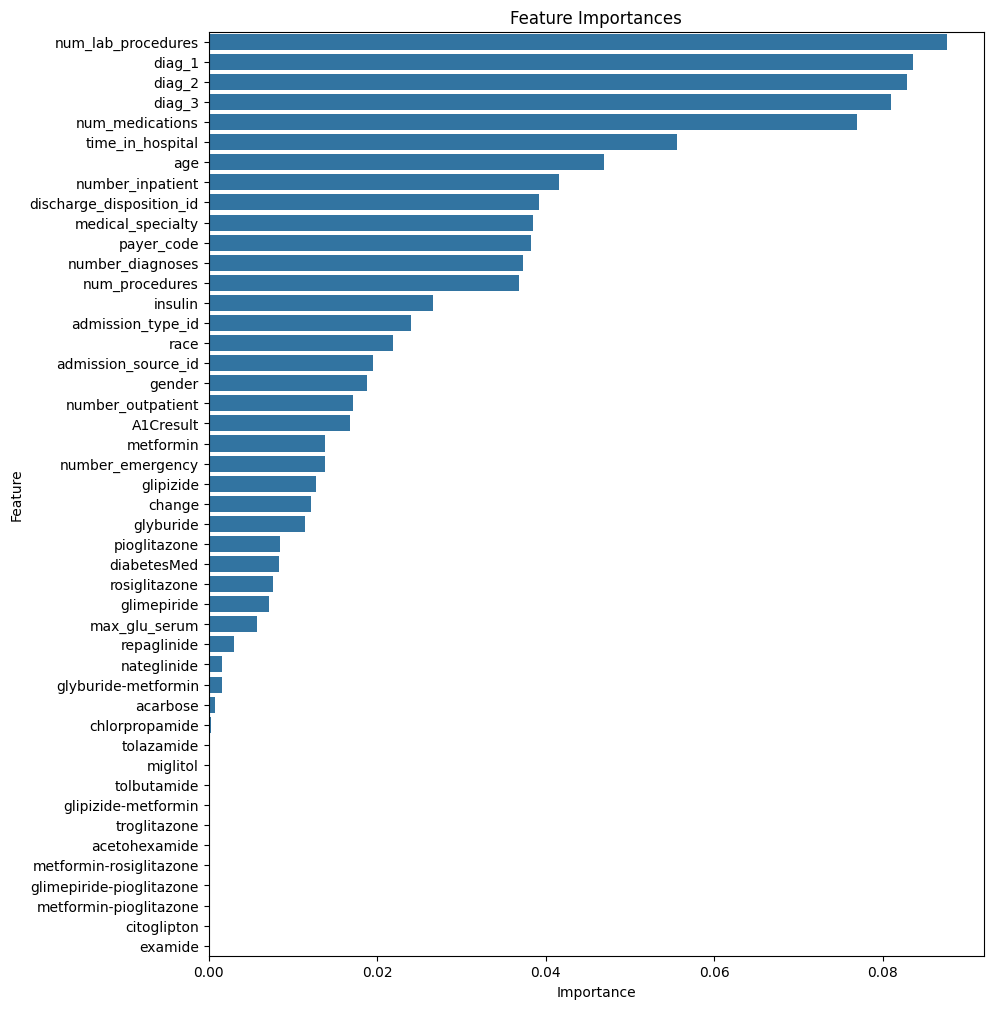

In [ ]:
from os import ST_NOSUID
##find correlation
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Train a Random Forest and extract feature importances
model = RandomForestClassifier()
model.fit(X_labelencoded_weight_removed, y)
feature_importances = pd.DataFrame({
    'Feature': X_labelencoded_weight_removed.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Bar Plot
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()


In [ ]:
##drop columns that have 0 importance
print(model.feature_importances_)
counter = 0
X_labelencoded_important_only = pd.DataFrame()
for i in range(len(model.feature_importances_)):
  if model.feature_importances_[i] > 0.01:
    # Get the column name
    column_name = X_labelencoded_weight_removed.columns[i]

    # Get the data for the column
    column_data = X_labelencoded_weight_removed[column_name]

    # Insert the column into the new DataFrame
    X_labelencoded_important_only.insert(counter, column_name, column_data)
    counter += 1
print(X_labelencoded_important_only)

[2.18886515e-02 1.88133683e-02 4.69790685e-02 2.39906974e-02
 3.92035702e-02 1.94656004e-02 5.55855845e-02 3.82366809e-02
 3.84558409e-02 8.76185769e-02 3.68101659e-02 7.69309541e-02
 1.71726515e-02 1.37836364e-02 4.15913795e-02 8.35548038e-02
 8.29289928e-02 8.10493774e-02 3.73296314e-02 5.76635331e-03
 1.67809145e-02 1.37980478e-02 3.06173785e-03 1.56781751e-03
 2.68079891e-04 7.17754233e-03 6.21350972e-06 1.27455746e-02
 1.14459756e-02 5.38022927e-05 8.51067504e-03 7.69684080e-03
 7.38059520e-04 9.00119176e-05 7.37508245e-06 1.12622549e-04
 0.00000000e+00 0.00000000e+00 2.66208887e-02 1.55339072e-03
 3.22283008e-05 1.27126061e-06 2.90751393e-06 2.98576469e-07
 1.22022115e-02 8.36992682e-03]
        race  gender  age  admission_type_id  discharge_disposition_id  \
0          2       0    0                  6                        25   
1          2       0    1                  1                         1   
2          0       0    2                  1                         1   
3

In [ ]:

def one_hot_encode_object_columns(df):
    object_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Create a OneHotEncoder instance
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Apply one-hot encoding to each object column
    for col in object_cols:
        # Reshape the column data for the encoder
        encoded_data = ohe.fit_transform(df[[col]])

        # Create column names for the encoded features
        feature_names = [f"{col}_{category}" for category in ohe.categories_[0]]

        # Create a DataFrame for the encoded features
        encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df.index)

        # Drop the original column and add the encoded features
        df = df.drop(columns=[col])
        df = pd.concat([df, encoded_df], axis=1)

    return df
X_for_model = one_hot_encode_object_columns(X_for_model)
y_for_model = one_hot_encode_object_columns(y_for_model)
from os import ST_NOSUID
##find correlation
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Train a Random Forest and extract feature importances
model = RandomForestClassifier()
model.fit(X_for_model, y_for_model)
feature_importances = pd.DataFrame({
    'Feature': X_for_model.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Bar Plot
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_labelencoded_important_only)


In [ ]:
from sklearn.preprocessing import LabelEncoder


def impute_missing_in_all_numerical_categories(data):
    # Select numerical features
    features = data.select_dtypes(include=['nominal']).columns
    # Check for missing values in any numerical feature
    if data[features].isnull().any().any() or data[numerical_features].isna().any().any():
        print("Missing values found in numerical categories. Applying imputation.")
        # Apply SimpleImputer with 'mean' strategy (you can change this)
        imputer = SimpleImputer(strategy='mean')
        data[eatures] = imputer.fit_transform(data[features])
    else:
        print("No missing values found in numerical categories.")

    return data

def check_column_for_non_nan(df, column_name):
  # Check if there are any non-NaN values in the specified column
  has_non_nan = df[column_name].notna().any()

  return has_non_nan


def print_non_nan_values(df, column_name):
  # Get all non-NaN values in the specified column
  non_nan_values = df[df[column_name].notna()][column_name]

  # Print the non-NaN values if any are found
  if non_nan_values.any():
    print("Non-NaN values in column", column_name + ":") #To see the output, run the code.
    print(non_nan_values) #To see the output, run the code.
    return True
  else:
    print("No non-NaN values found in column", column_name) #To see the output, run the code.
    return False


label_encoder = LabelEncoder()
X['weight_encoded'] = label_encoder.fit_transform(X['weight'])
print(X)

                   race  gender      age weight  admission_type_id  \
0             Caucasian  Female   [0-10)    NaN                  6   
1             Caucasian  Female  [10-20)    NaN                  1   
2       AfricanAmerican  Female  [20-30)    NaN                  1   
3             Caucasian    Male  [30-40)    NaN                  1   
4             Caucasian    Male  [40-50)    NaN                  1   
...                 ...     ...      ...    ...                ...   
101761  AfricanAmerican    Male  [70-80)    NaN                  1   
101762  AfricanAmerican  Female  [80-90)    NaN                  1   
101763        Caucasian    Male  [70-80)    NaN                  1   
101764        Caucasian  Female  [80-90)    NaN                  2   
101765        Caucasian    Male  [70-80)    NaN                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
0                             25                    1                 1   
1        

<ipython-input-54-ee970b9f9a4c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['weight_encoded'] = label_encoder.fit_transform(X['weight'])
